# Section 1: Import of data and general tools

In this section we will import necessary tools and data for our regression and classification tasks.
First, we import data and libraries necessary for the research.

In [26]:
# shutting down warnings
import warnings
warnings.filterwarnings("ignore")

# import of general libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

# import of sklearn metrics, scalers and models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, RidgeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# defining random state for repeatability of the code
RANDOM_STATE = 319

#### Data import
The data itself is not part of the git repository. Please, change relative paths to the data on our machine in case those are differ from ones stated below. Original source of data is presented in README.txt file.

In [27]:
# defining path for training dataset and data import
PATH_REG_TRAIN = "./bitrate_prediction/bitrate_train.csv"
PATH_REG_TEST = "./bitrate_prediction/bitrate_test.csv"
PATH_CLASS_TRAIN = "./stream_quality_data/train_data.csv"
PATH_CLASS_TEST = "./stream_quality_data/test_data.csv"

x_train_c = pd.read_csv(PATH_CLASS_TRAIN)
x_test_c = pd.read_csv(PATH_CLASS_TEST)
x_train_r = pd.read_csv(PATH_REG_TRAIN)
x_test_r = pd.read_csv(PATH_REG_TEST)

#### Custom functions for later use
In this sub-section we will define few custom functions which will help us with visualisation, model evaluation and other tasks.

First, we define a few functions for visualizing our data:

In [91]:
def plot_confusion_matrix(y_true: np.array, y_pred: np.array)-> np.ndarray:
    """
    Function plots confusion matrix with indication of concrete values.
    :param y_true: true labels
    :param y_pred: predicted labels
    :return: confusion matrix
    """
    fig, ax = plt.subplots()
    cm = confusion_matrix(y_true, y_pred)
    fig.set_size_inches((4,4))
    ax.imshow(cm, cmap="gray")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="red")
    plt.show()

    return cm

def plot_dataset(ds: pd.DataFrame, labels: pd.Series, alpha: float = 0.005)-> None:
    """
    Plots all features from dataset in three columns:
    1st column plots scatter of a pair of Nth and Nth+1 features
    2nd column plots scatter of a pair of Nth feature and label
    3rd column plots scatter of a pair of Nth+1 feature and label
    Additionally, function plots red lines establishing the means of the features
    :param ds: dataset for plotting
    :param labels: a series, which will be plotted against each feature
    :param alpha: density variable
    :return: None
    """

    rows = ds.shape[1]//2+ds.shape[1]%2
    fig, ax = plt.subplots(rows, 3)
    fig.set_size_inches(12,4 * rows)
    for i in range(0, ds.shape[1]-1, 2):
        row = i//2
        ax[row, 0].scatter(ds.iloc[:,i], ds.iloc[:,i+1], alpha=alpha)
        ax[row, 0].axvline(np.mean(ds.iloc[:,i]), c = 'red')
        ax[row, 0].axhline(np.mean(ds.iloc[:,i+1]), c = 'red')
        ax[row, 0].set_title(f'{ds.columns[i]} | {ds.columns[i+1]}')

        ax[row, 1].scatter(ds.iloc[:,i], labels, alpha=alpha)
        ax[row, 1].axvline(np.mean(ds.iloc[:,i]), c = 'red')
        ax[row, 1].set_title(f'{ds.columns[i]} | target')

        ax[row, 2].scatter(ds.iloc[:,i+1], labels, alpha=alpha)
        ax[row, 2].axvline(np.mean(ds.iloc[:,i+1]), c = 'red')
        ax[row, 2].set_title(f'{ds.columns[i+1]} | target')

    if ds.shape[1]//2 == 1:
        ax[ds.shape[1]//2, 1].scatter(ds.iloc[:,-1], labels, alpha=alpha)
        ax[ds.shape[1]//2, 1].set_title(f'{ds.columns[-1]} | target')
    plt.show()

    return None

def plot_boxplots(ds: pd.DataFrame)-> None:
    """
    Plots boxplots of each feature in dataset.
    :param ds: dataset
    :return: None
    """
    rows = ds.shape[1]//3 + int(ds.shape[1]%3!=0)
    fig, ax = plt.subplots(rows, 3)
    fig.set_size_inches(12,rows * 4)

    for i, n in enumerate(ds.columns):
        ax[i//3, i%3].boxplot(ds[n])
        ax[i//3, i%3].set_title(n)

def plot_corr_matrix(ds: pd.DataFrame)-> pd.DataFrame:
    """
    Function plots correlation matrix
    :param ds: dataset
    :return: raw correlation matrix
    """
    cols = ds.columns
    data = np.round(ds.corr(),2)

    fig, ax = plt.subplots()
    fig.set_size_inches((12,12))
    ax.imshow(data, cmap="gray")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(cols.shape[0]), labels=cols)
    ax.set_yticks(np.arange(cols.shape[0]), labels=cols)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(cols.shape[0]):
        for j in range(cols.shape[0]):
            text = ax.text(j, i, data.iloc[i, j],
                           ha="center", va="center", color="red")

    fig.tight_layout()
    plt.show()

    return data


Then we will define a function which will help us efficiently evaluate our models. The function will accept data which passed feature engineering / scaling and evaluate pre-trained model or train model itself using train data.

In [29]:
def evaluate_model(model: 'ML model',
                   x_train: pd.DataFrame=False, y_train: pd.Series=False,
                   x_test: pd.DataFrame=False, y_test: pd.Series=False,
                   metrics: dict={"r2_score" : r2_score, "mse" : mean_squared_error},
                   fit_model: bool= False)-> list:
    """
    Function accepts model for evaluation and use passed metrics to measure it's performance on test data. If needed, function can train model using train data.
    :param model: an ML model class object with fit() and predict() methods.
    :param x_train: dataset for model training. If test data is absent, model evaluate it's performance on train data.
    :param y_train: train labels. If test data is absent, model evaluate it's performance on train data.
    :param x_test: dataset for model evaluation
    :param y_test: labels for model evaluation
    :param metrics: dictionary of metrics required for evaluation
    :param fit_model: model training flag. If True, model will be fitted on train data
    :return: returns list of scores, trained model and predicted labels
    """
    if type(x_test) == bool or type(y_test) == bool:
        x_test = x_train
        y_test = y_train

    if fit_model:
        model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    scores = {}
    for t in metrics.keys():
        scores.update({t : metrics[t](y_test, y_pred)})

    return scores, model, y_pred


Finally, we will define our class of ML polynomial model. This will allow us efficiently create models with polynomial features.

In [30]:
class Polynomial:
    """
    Allows to fit any model using polynomial features
    """
    def __init__(self, degree=2, model=LinearRegression()):
        self.degree = degree
        self.model = model

    def fit(self, X, y):
        self.poly_transform = PolynomialFeatures(self.degree).fit(X)
        self.model.fit(self.poly_transform.transform(X), y)

    def predict(self, X):
        return self.model.predict(self.poly_transform.transform(X))


# Section 2: Regression problem
In this section we will look at the problem of predicting bitrate based in cloud gaming session data. During our research we will take a look at data, determine feature engineering process and measure performance of a few models.


#### Section 2.1: Regression data visualization and overview
In this section we will perform general overview of our data and determine general hypothesis regarding feature engineering process.

First, let's look at general statistics of our features:

I note that maximum values of each feature drastically differs from 75% quantiles which indicated highly imbalanced features and huge amount of noise on data.

Among the features' names we can clearly define our target column called 'target'. However, two more columns are most likely connected with our bitrate prediction goal - "bitrate_std" and "bitrate_mean". Research on dependency of a variable mean or std to the variable itself would not have been useful as we usually do not possess knowledge of a variable's distribution. Thus, we will eliminate those columns later.

As it is shown in output below, all features are numerical and thus feature encoding is not necessary for this case. There are no empty data either thus we do not need to impute empty values.

In [62]:
x_train_r.describe()

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std,target
count,379021.000000,379021.000000,379021.000000,379021.000000,379021.000000,379021.000000,379021.000000,379021.000000,379021.000000,379021.000000
mean,35.231127,1.725705,49.623858,12.763672,0.180451,0.469548,1.450719,7516.585502,1603.487501,7525.396231
std,10.975010,2.505942,94.781098,112.684460,1.732890,3.157866,9.670928,6073.992189,1721.021623,6070.817736
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.800000,0.316228,14.300000,0.699206,0.000000,0.000000,0.000000,2773.300000,383.683550,2785.000000
50%,30.000000,0.942809,32.200000,1.433721,0.000000,0.000000,0.000000,6287.200000,1112.710010,6296.000000
75%,43.600000,2.233582,55.900000,4.948625,0.000000,0.000000,0.000000,10187.200000,2241.848801,10192.000000
max,125.800000,307.167273,12898.400000,40721.933293,540.000000,202.385770,640.000000,64913.500000,26908.532303,64913.000000


Let's take a look at the correlation matrix:

As it shown below, bitrate_mean and bitrate_std are highly correlated to each other and to the target thus one probably is derived from another.

In addition, dropped_frames_max and dropped_frames_std are highly correlated with each other. Thus, deletion of one of those features will not seriously impact the model's outcome.

The rest of the features are barely correlate with the target variable which will make creation of linear model challenging as there is no linear correlation between the features and the target. fps_mean variable promises to be the most useful feature as it has the highes correlation coefficient (0.2) with the target.


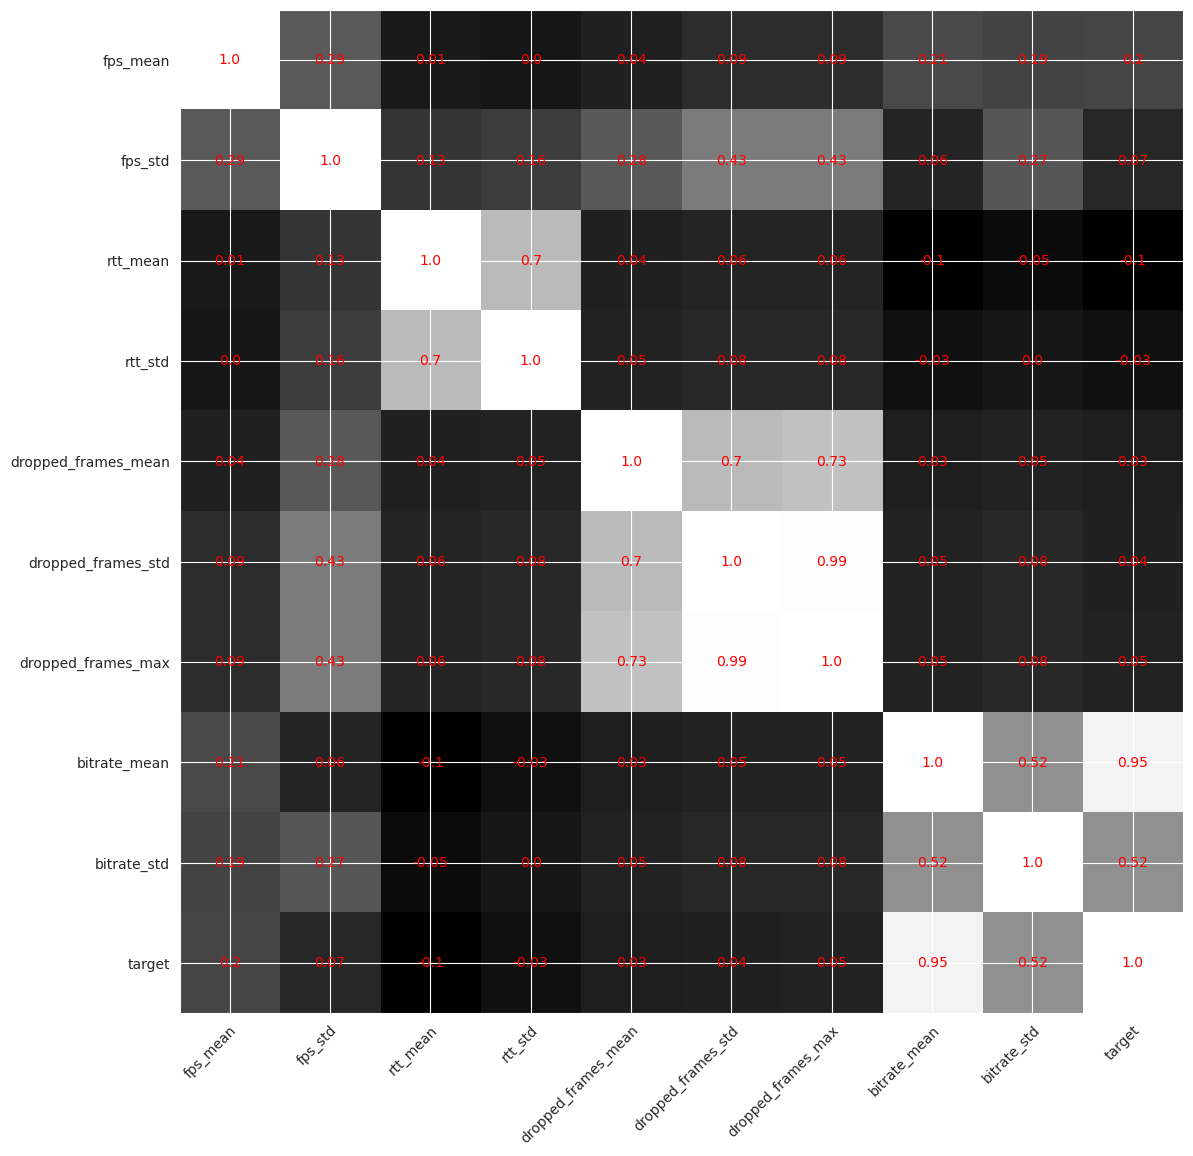

In [63]:
_ = plot_corr_matrix(x_train_r)

Now we will plot boxplots and get a perspective on data distribution.
As it shown below, on a most of the plots boxes are not even visible, indicating that maximum values are strongly higher or lower of the respective quantiles. Variables most of the features have deliberate outliers which we will clear later during the project.

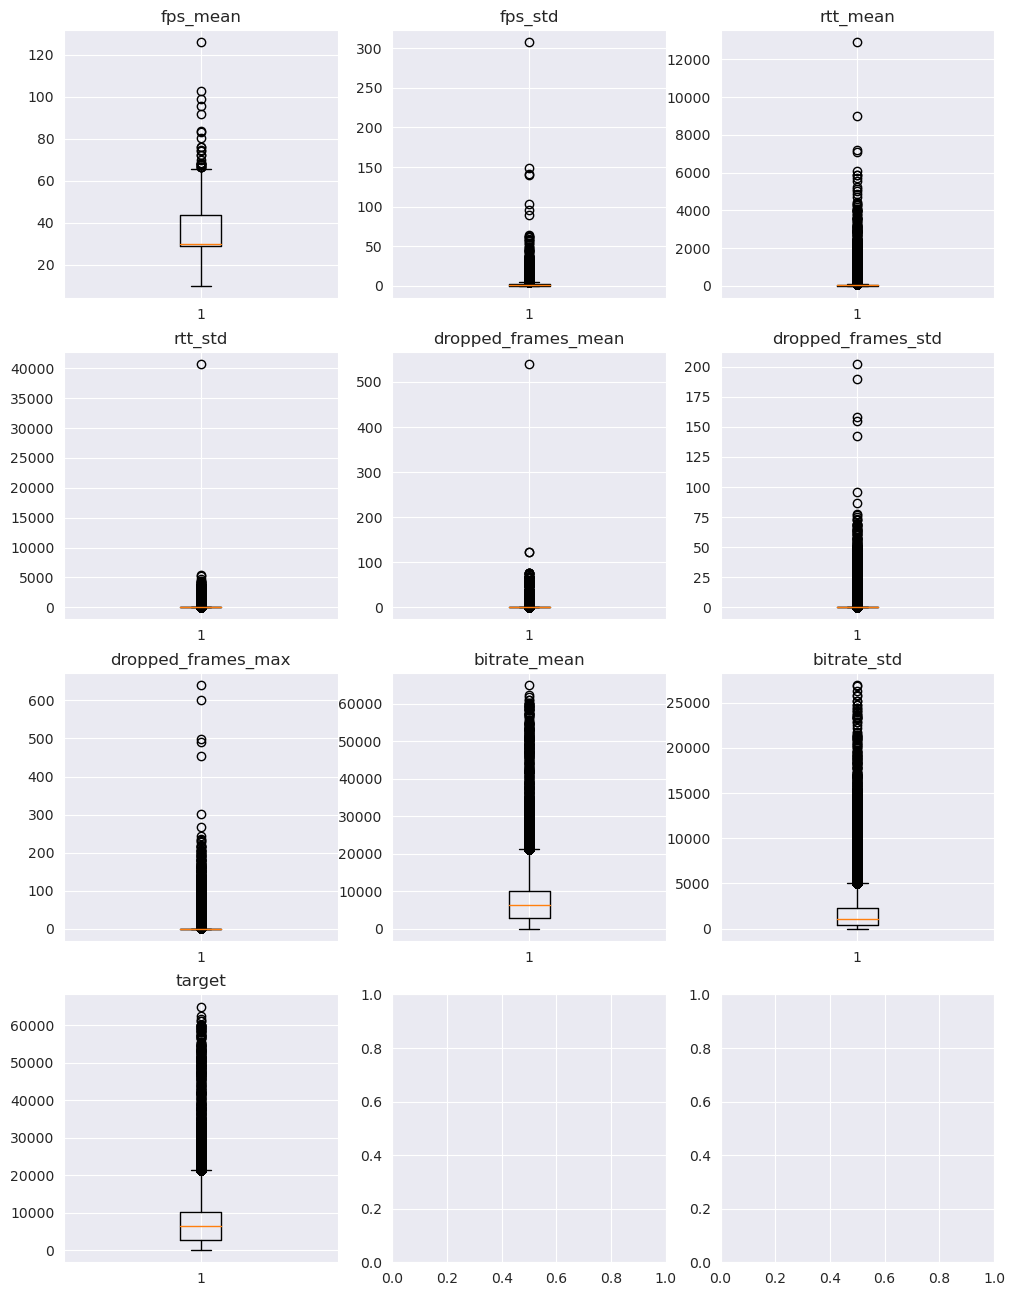

In [64]:
plot_boxplots(x_train_r)

So let's try to "zoom in" on data and try to identify outliers. Based on boxplot above we will filter some outliers and fix a number of discarded observations.

As it shown in output below, even removing 12% of the dataset, we still observing potential outliers in many variables. However, boxplots themselves are at least visible which indicates improvements in the data distribution.

Extracting more observation may impact generalisation of the model which will make it less stable on different dataset. Thus, we will not eliminate any more outliers at the moment.

Initial shape: (379021, 10)
Current shape: (331977, 10)
Overall reduction: 0.12


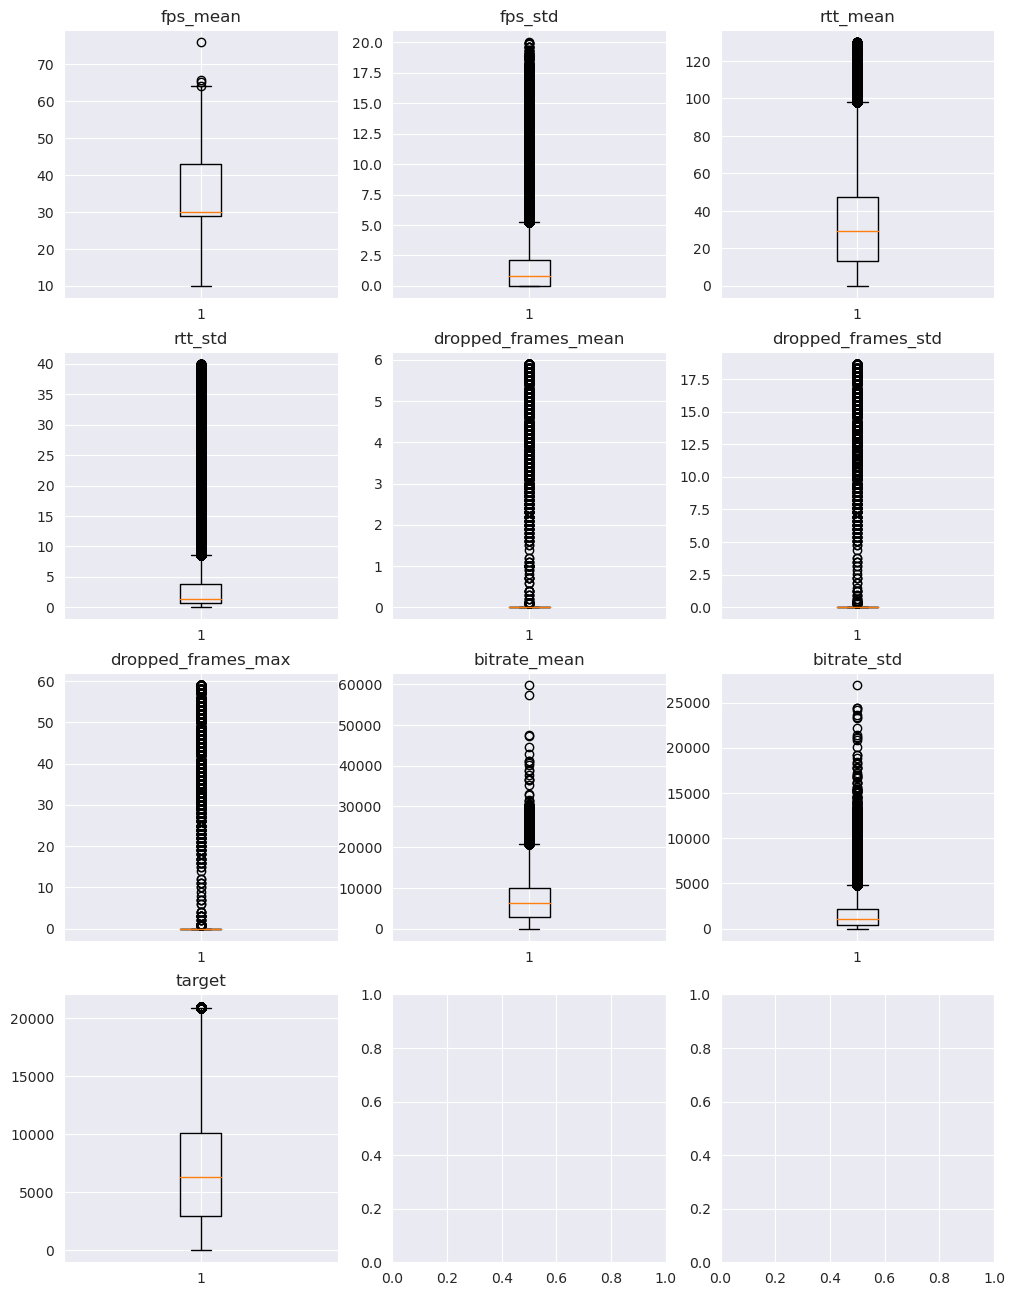

In [144]:
x_train_r_no_outl = x_train_r.copy()
x_train_r_no_outl = x_train_r_no_outl.loc[x_train_r_no_outl["rtt_std"] < 40]
x_train_r_no_outl = x_train_r_no_outl.loc[x_train_r_no_outl["rtt_mean"] < 130]
x_train_r_no_outl = x_train_r_no_outl.loc[(x_train_r_no_outl["fps_mean"] < 80)]
x_train_r_no_outl = x_train_r_no_outl.loc[(x_train_r_no_outl["dropped_frames_mean"] < 6)]
x_train_r_no_outl = x_train_r_no_outl.loc[(x_train_r_no_outl["dropped_frames_std"] < 20)]
x_train_r_no_outl = x_train_r_no_outl.loc[(x_train_r_no_outl["fps_std"] < 20)]
x_train_r_no_outl = x_train_r_no_outl.loc[(x_train_r_no_outl["target"] < 21000) ]

print(f"Initial shape: {x_train_r.shape}")
print(f"Current shape: {x_train_r_no_outl.shape}")
print(f"Overall reduction: {np.round(1 - x_train_r_no_outl.shape[0] / x_train_r.shape[0], 2)}")

plot_boxplots(x_train_r_no_outl)

Now we will plot out data and will try to identify any potential additional features. Below we can trends of all features against the target and against some plots of features against each other. Red lines indicates mean values of corresponding features.

First of all, we can notice that there is no clear linear dependency between features and the target (excluding bitrate data which we cannot use as was stated above). This conclusion is also supported by correlation analysis conducted above.

If we look at the plot fps_mean | target we can notice that there is a cluster of data which stands out between x values 25-35. This cluster seems independent of the whereas the rest of the dataset does demonstrate a little trend. We can try to assume that 25-35 fps rate is some kind of stable state which is not dependent on the bitrate. Thus, we can try to formulate external binary feature representing that fps_mean is indeed at it's 'stable' state so the model can put negative coefficient to minimize fps_mean contribution in such cases.

Then, we can pay attention to fps_std, rtt_std and rtt_mean features. There we can notice that higher values of the features may correspond with low target value. We can add binary features representing high values to help the model identify potentially low value bitrate.

Then, we can pay attention to fps_std and rtt_std distribution. A lot of observations contain values highly superior to corersponding mean values. We may add logariphmic features to short the distance between average and high values.

Finally, dropped_frames features seems to have either 0 value or values which are not corresponding to the target value. Thus, it is probably safe to exclude them from the analysis. However, it would be logical to add a feature, representing the occurance of dropped frames.

Of course, we can see high correlation between bitrate_mean and target value which is also was seen during correlation analysis.


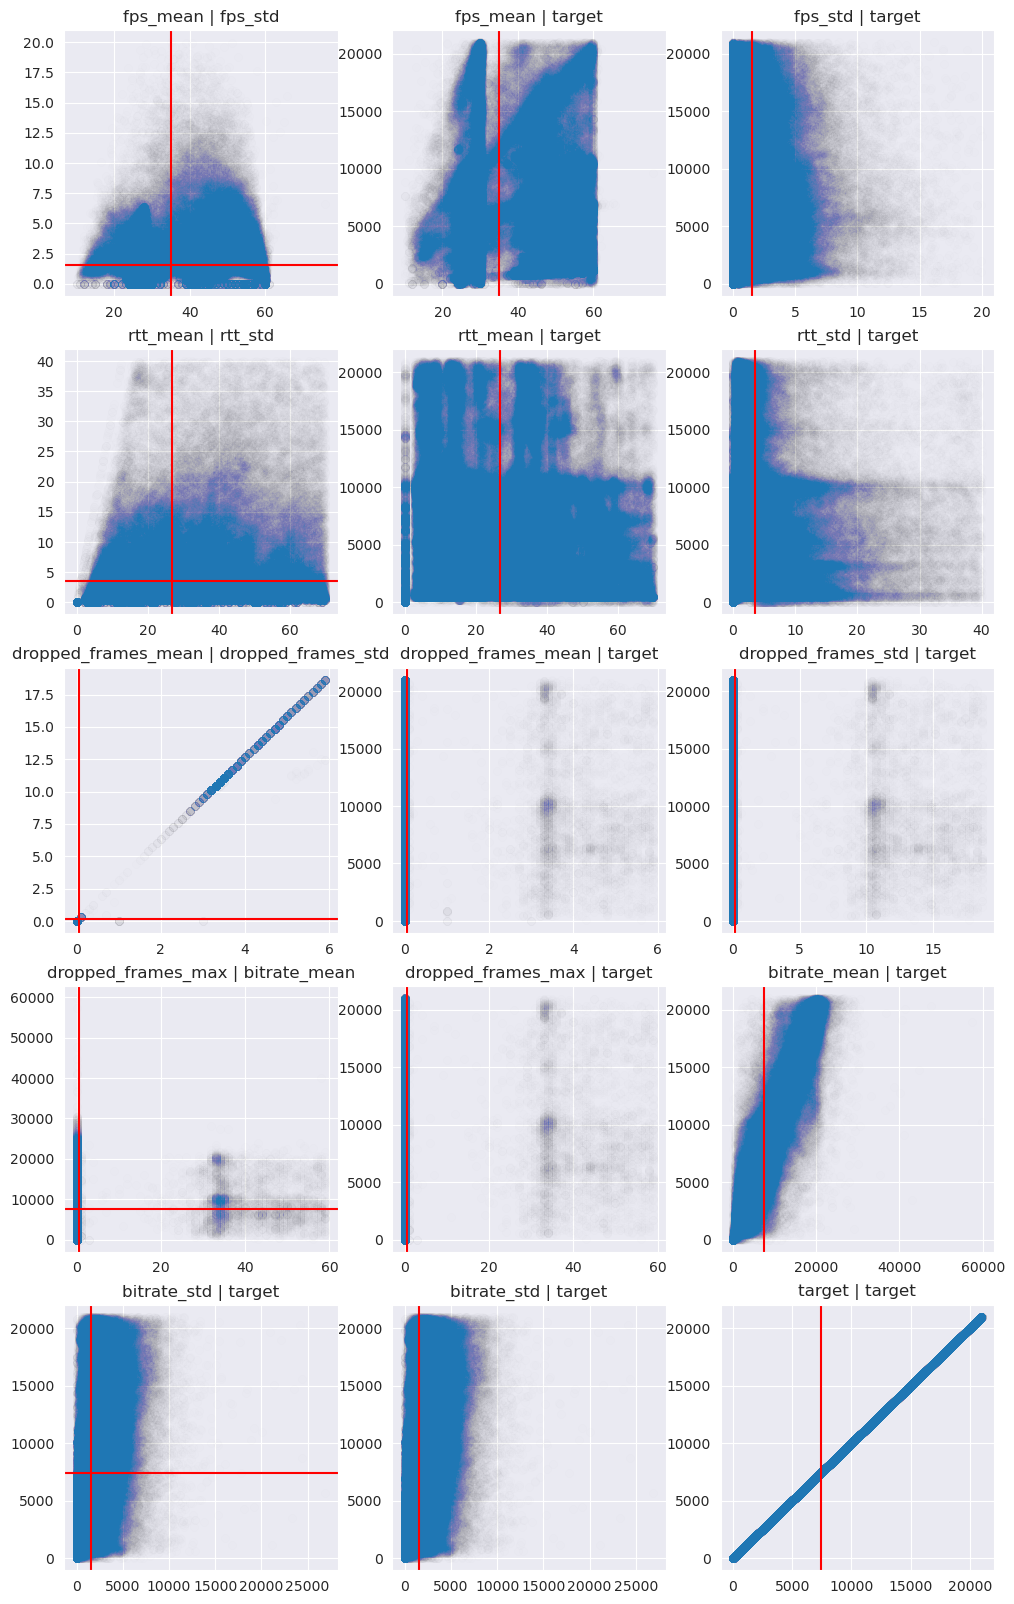

In [66]:
plot_dataset(x_train_r_no_outl, x_train_r_no_outl["target"], alpha=0.005)

Now we will conduct a PCA analysis of the features.

Unfortunately, it does not seem to have a strong effect as PCA 1 does not show any useful dependencies on the target.

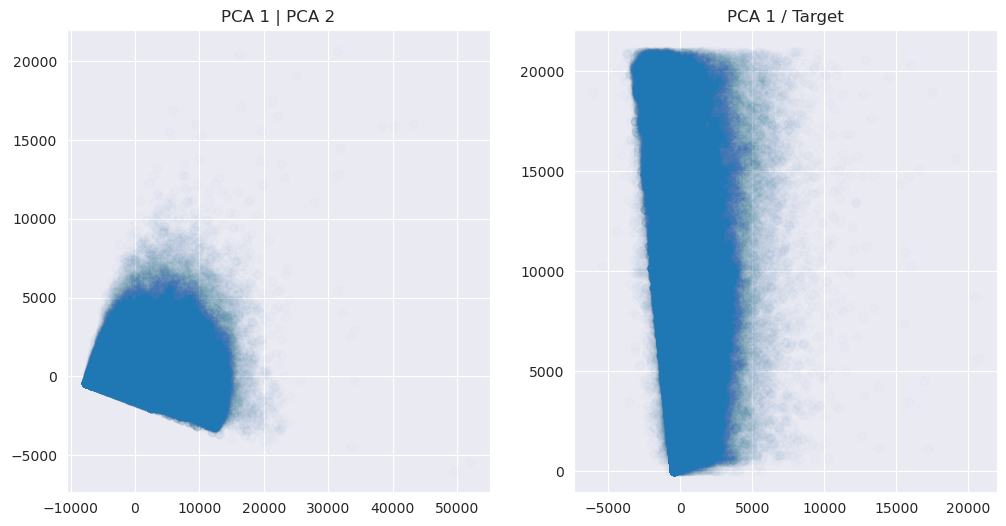

In [68]:
from sklearn.decomposition import PCA

pca = PCA(2).fit(x_train_r_no_outl.drop("target", axis=1), x_train_r_no_outl["target"])
x_train_pca = pca.transform(x_train_r_no_outl.drop("target", axis=1))
#x_train_pca = np.array(list(map(lambda x: min(x[0], 2), x_train_pca)))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 6)

ax[0].scatter(x_train_pca[:,0], x_train_pca[:,1], alpha = 0.01)
ax[0].set_title("PCA 1 | PCA 2")
#ax[0].set_ylim([-4, 4])
#ax[0].set_xlim([-3, 4])
ax[1].scatter(x_train_pca[:,1], x_train_r_no_outl["target"], alpha = 0.01)
ax[1].set_title("PCA 1 / Target")
#ax[1].set_xlim([-3, 10])
plt.show()

#### Section 2.2: Feature engineering

Now we will put everything we learned from visualization into our feature engineering strategy. We will transform our data according to our findings and evaluate usefulness of the features by looking at coefficients of trained linear model.

According to our findings, we will create a function which will transform the data by the following rules:
    1. For training dataset we will exclude outliers found in section 2.2
    2. For any dataset we will add binary features and log features identified in section 2.2
    3. We will scale our data
    4. We will drop duplicated observations

As was expected, we lost appx. 23% of the data during the process.

In [150]:
scaler = None
def reg_pipe(X_: pd.DataFrame, y: pd.Series = False, fit_mode = False, final=True)->pd.DataFrame:
    X = X_.copy()

    print(f'Initial data shape: {X.shape}')

    # dropping bitrate features
    X.drop(["bitrate_mean", "bitrate_std"], inplace=True, axis=1)

    # adding binary features
    X['dropped_frames_occured'] = X['dropped_frames_mean'].apply(lambda x: np.int8(x>0))
    X['fps_std'] = X['fps_std'].apply(lambda x: x>6)
    X['fps_unstable'] = X['fps_std'].apply(lambda x: x>5)
    X['rtt_unstable'] = X['rtt_std'].apply(lambda x: x>5)
    X['fps_anomaly'] = X['fps_mean'].apply(lambda x: not (x>25 and x<35))
    X['rtt_anomaly'] = X['rtt_mean'].apply(lambda x: x>50)

    # adding logarithmic features
    X["fps_std_log"] = X["fps_std"].apply(lambda x: np.log(x) if x>2 else x)
    X['rtt_std_log'] = X['rtt_std'].apply(lambda x: np.log(x) if x>2 else x)
    X.drop(["dropped_frames_mean"], axis=1, inplace=True)

    # dropping non-dependent features


    if fit_mode:
        X["target"] = y

        # dropping duplicates
        X.drop_duplicates(inplace = True)

        # dropping outliers
        X = X.loc[X["rtt_std"] < 40]
        X = X.loc[(X["fps_std"] < 20)]
        X = X.loc[(X["fps_mean"] < 80)]
        X = X.loc[(X["target"] < 21000) ]
        X = X.loc[X["rtt_mean"] < 130]

    X.drop(["dropped_frames_std", 'dropped_frames_max'], inplace=True, axis=1)
    if final:
        X.drop(["rtt_mean"], inplace=True, axis=1)

    if "target" in X.columns:
        y = X["target"]
        X = X.drop("target", axis=1)

    # scaling the data
    global scaler
    if fit_mode:
        scaler = MinMaxScaler().fit(X)
    X = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

    print(f'Out data shape: {X.shape}')
    if type(y) != bool:
        return X, y
    return X


In [151]:
x_train_r_no_target = x_train_r.drop(["target"], axis=1)
x_train_r_piped, y_train_r = reg_pipe(x_train_r_no_target, x_train_r["target"], fit_mode=True, final=False)

Initial data shape: (379021, 9)
Out data shape: (331012, 11)


Now let us train a simple regression model and look at the coefficients to determine contribution of each feature.

Most of the coefficients does contribute into the model with exception to rtt_mean. We can safely remove it without distrupting the model.

In [152]:
model = LinearRegression(fit_intercept=True).fit(x_train_r_piped, y_train_r)
y_train_pred_r = model.predict(x_train_r_piped)

print(f'r2_score: {r2_score(y_train_r, y_train_pred_r)}')
print(f'root mean squared error: {mean_squared_error(y_train_r, y_train_pred_r, squared=False)}')

pd.DataFrame(model.coef_, x_train_r_piped.columns)

r2_score: 0.09411874331351011
root mean squared error: 4999.32996147976


,0
fps_mean,9.001818e+03
fps_std,3.514367e+14
rtt_mean,-3.167551e+02
rtt_std,-2.435109e+03
dropped_frames_occured,2.210355e+03
fps_unstable,1.406789e+08
rtt_unstable,-1.470063e+03
fps_anomaly,-1.554068e+03
rtt_anomaly,-1.955995e+03
fps_std_log,-3.514367e+14


If we look at the model trained without the feature, we can observe that the scores actually went up a bit.
Additionally, we can note that fps_mean seems to be the most important feature for the model.

In [153]:
x_train_r_piped, y_train_r = reg_pipe(x_train_r_no_target, x_train_r["target"], fit_mode=True)

model = LinearRegression(fit_intercept=True).fit(x_train_r_piped, y_train_r)
y_train_pred_r = model.predict(x_train_r_piped)

print(f'r2_score: {r2_score(y_train_r, y_train_pred_r)}')
print(f'root mean squared error: {mean_squared_error(y_train_r, y_train_pred_r, squared=False)}')

pd.DataFrame(model.coef_, x_train_r_piped.columns)

Initial data shape: (379021, 9)
Out data shape: (331012, 10)
r2_score: 0.09406931846456823
root mean squared error: 4999.466341251448


,0
fps_mean,9.000363e+03
fps_std,3.556713e+14
rtt_std,-2.441499e+03
dropped_frames_occured,2.210392e+03
fps_unstable,-9.431712e+07
rtt_unstable,-1.472578e+03
fps_anomaly,-1.558234e+03
rtt_anomaly,-2.082617e+03
fps_std_log,-3.556713e+14
rtt_std_log,2.287054e+03


Now we will revisit our boxplots to check if our feature engineering excersize did affect dataset distribution.

As shown below, our efforts transformed the data into more feasible values with limited amount of potential outliers.

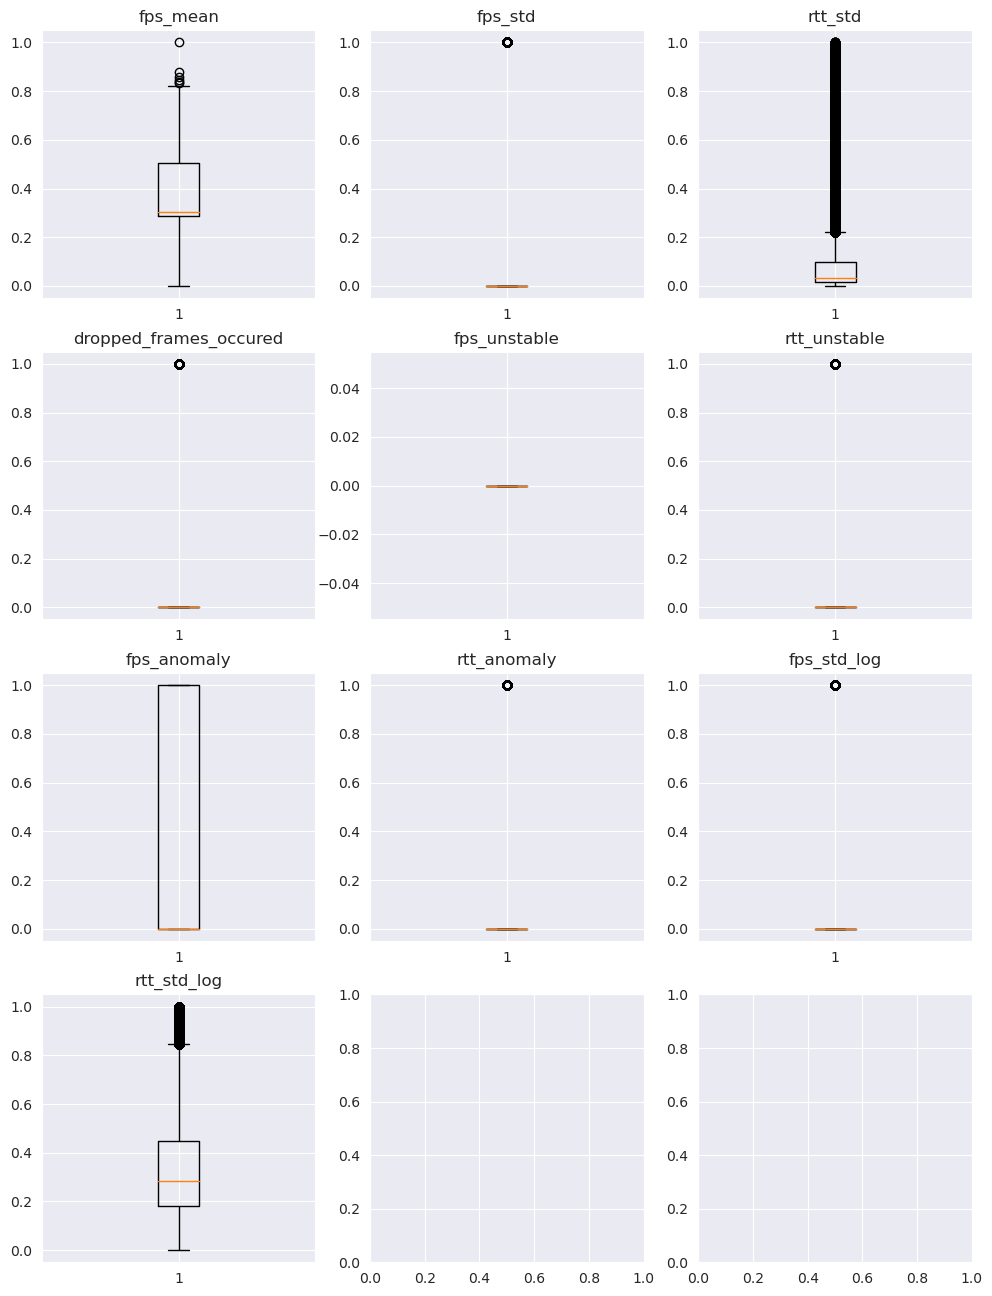

In [146]:
plot_boxplots(x_train_r_piped)

#### Section 2.3: training and evaluation of the models

In this section we will focus on metric selection and comparison of various models.
We will use 4 kinds of models for our regression task:
    1. Simple Linear Regression model
    2. Simple Linear Regression model with Lasso regularization
    3. Simple Linear Regression model with Ridge regularization
    4. Simple Linear Regression model with Polynomial features
Models 2-4 will require some hyperparametrs to be optimized. Specifically, we have to determine alpha coefficient for Ridge and Lasso and degree for polynomial features.

First, we will experiment with alpha coefficients.
As it shown below, we can make assumption that lower coefficients are shows slightly better results. However, overall performance does not differ from simple linear model.
We can also note slight increase in Root squared error compared to the model trained above which is logical as here we use whole dataset including outliers.

In [157]:
metrics = {
    "r2_score" : r2_score,
    "Root Squared Mean Error" : lambda x, y: mean_squared_error(x, y, squared=False)
}

models = {
    "Simple Linear" : LinearRegression(),
    "Ridge_0.1" : Ridge(0.1),
    "Ridge_0.4" : Ridge(0.4),
    "Ridge_0.7" : Ridge(0.7),
    "Ridge_1.0" : Ridge(1.0),
    "Lasso_0.1" : Lasso(0.1),
    "Lasso_0.4" : Lasso(0.4),
    "Lasso_0.7" : Lasso(0.7),
    "Lasso_1.0" : Lasso(1.0),
}

x_train_piped, y_train_r = reg_pipe(x_train_r.drop("target", axis=1), x_train_r["target"])
for n in models:
    print(f'{n}: {evaluate_model(models[n], x_train_piped, y_train_r, metrics=metrics, fit_model=True)[0]}')


Initial data shape: (379021, 9)
Out data shape: (379021, 10)
Simple Linear: {'r2_score': 0.10221863822177346, 'Root Squared Mean Error': 5752.172663839108}
Ridge_0.1: {'r2_score': 0.10221980850919854, 'Root Squared Mean Error': 5752.168914765104}
Ridge_0.4: {'r2_score': 0.10221980825889698, 'Root Squared Mean Error': 5752.168915566958}
Ridge_0.7: {'r2_score': 0.10221980770831385, 'Root Squared Mean Error': 5752.168917330779}
Ridge_1.0: {'r2_score': 0.1022198068575445, 'Root Squared Mean Error': 5752.168920056261}
Lasso_0.1: {'r2_score': 0.10221973810002338, 'Root Squared Mean Error': 5752.1691403244695}
Lasso_0.4: {'r2_score': 0.10221857749121555, 'Root Squared Mean Error': 5752.172858392406}
Lasso_0.7: {'r2_score': 0.10221616419413615, 'Root Squared Mean Error': 5752.180589501718}
Lasso_1.0: {'r2_score': 0.10221302263283938, 'Root Squared Mean Error': 5752.190653623716}


In [173]:
from sklearn.model_selection import cross_validate

x_train_r_piped, y_train_r = reg_pipe(x_train_r.drop("target", axis=1), x_train_r["target"], fit_mode=True)

cv = cross_validate(LinearRegression(), x_train_r_piped, y_train_r, cv=4, return_train_score=True, scoring='neg_root_mean_squared_error')
cv

Initial data shape: (379021, 9)
Out data shape: (331012, 10)


{'fit_time': array([0.07183027, 0.0565424 , 0.0581882 , 0.05810595]),
 'score_time': array([0.01015282, 0.00243568, 0.0031004 , 0.00237608]),
 'test_score': array([-5050.39939083, -5407.98870538, -4775.64068933, -4873.87383472]),
 'train_score': array([-4988.49329521, -4861.28900362, -5076.12888233, -5050.34142675])}

In [48]:
    metrics = [r2_score, lambda x, y: mean_squared_error(x, y, squared=False)]
models = [LinearRegression(),
          Ridge(1),
          Lasso(1),
          Polynomial(2),
          Polynomial(3)]

poly_degree=2
poly_transform = PolynomialFeatures(poly_degree).fit(x_train_piped)

x_train_r_piped, y_train = reg_pipe(x_train_r.drop("target", axis=1), x_train_r["target"])
for n in models:
    print(evaluate_model(n, x_train_piped, y_train, metrics=metrics)[0])
#x_train_poly = poly_transform.transform(x_train_piped)
#print(evaluate_model(LinearRegression(), x_train_poly, y_train, metrics=metrics)[0])
#print(evaluate_model(Ridge(), x_train_poly, y_train, metrics=metrics)[0])

x_test_piped, y_test = reg_pipe(x_test_r.drop("target", axis=1), x_test_r["target"])
for n in models:
    print(evaluate_model(n, x_train_piped, y_train, x_test_piped, y_test,metrics=metrics)[0])
#x_test_poly = poly_transform.transform(x_test_piped)
#print(evaluate_model(LinearRegression(), x_train_poly, y_train, x_test_poly, y_test, metrics=metrics)[0])
#print(evaluate_model(Ridge(), x_train_poly, y_train, x_test_poly, y_test, metrics=metrics)[0])


(379021, 10)


NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
x_test_piped

In [ ]:
plot_dataset(x_test_r,x_test_r["target"], alpha=0.002)

###Classification




In [49]:
x_train_c_embbedded = x_train_c.copy()
x_train_c_embbedded["auto_bitrate_state"] = x_train_c_embbedded["auto_bitrate_state"].apply(lambda x: x!="off")
x_train_c_embbedded["auto_fec_state"] = x_train_c_embbedded["auto_fec_state"].apply(lambda x: x!="off")
x_train_c_embbedded

,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_bitrate_state,auto_fec_state,auto_fec_mean,stream_quality
0,24.4,0.516398,0,91.1,6.723921,0.0,0.0,0.0,False,True,50.0,0
1,28.6,2.065591,0,99.7,15.923777,0.0,0.0,0.0,False,True,50.0,0
2,30.0,0.000000,0,98.1,11.798776,0.0,0.0,0.0,False,True,50.0,0
3,30.3,0.948683,0,99.4,13.014522,0.0,0.0,0.0,False,True,50.0,0
4,29.9,0.316228,0,123.2,62.476307,0.0,0.0,0.0,False,True,50.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
406567,40.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0,True,True,50.0,0
406568,40.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0,True,True,50.0,0
406569,40.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0,True,True,50.0,0
406570,40.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0,True,True,50.0,0


In [50]:
show_corr(x_train_c_embbedded)

NameError: name 'show_corr' is not defined

(406572, 12)
(381533, 12)


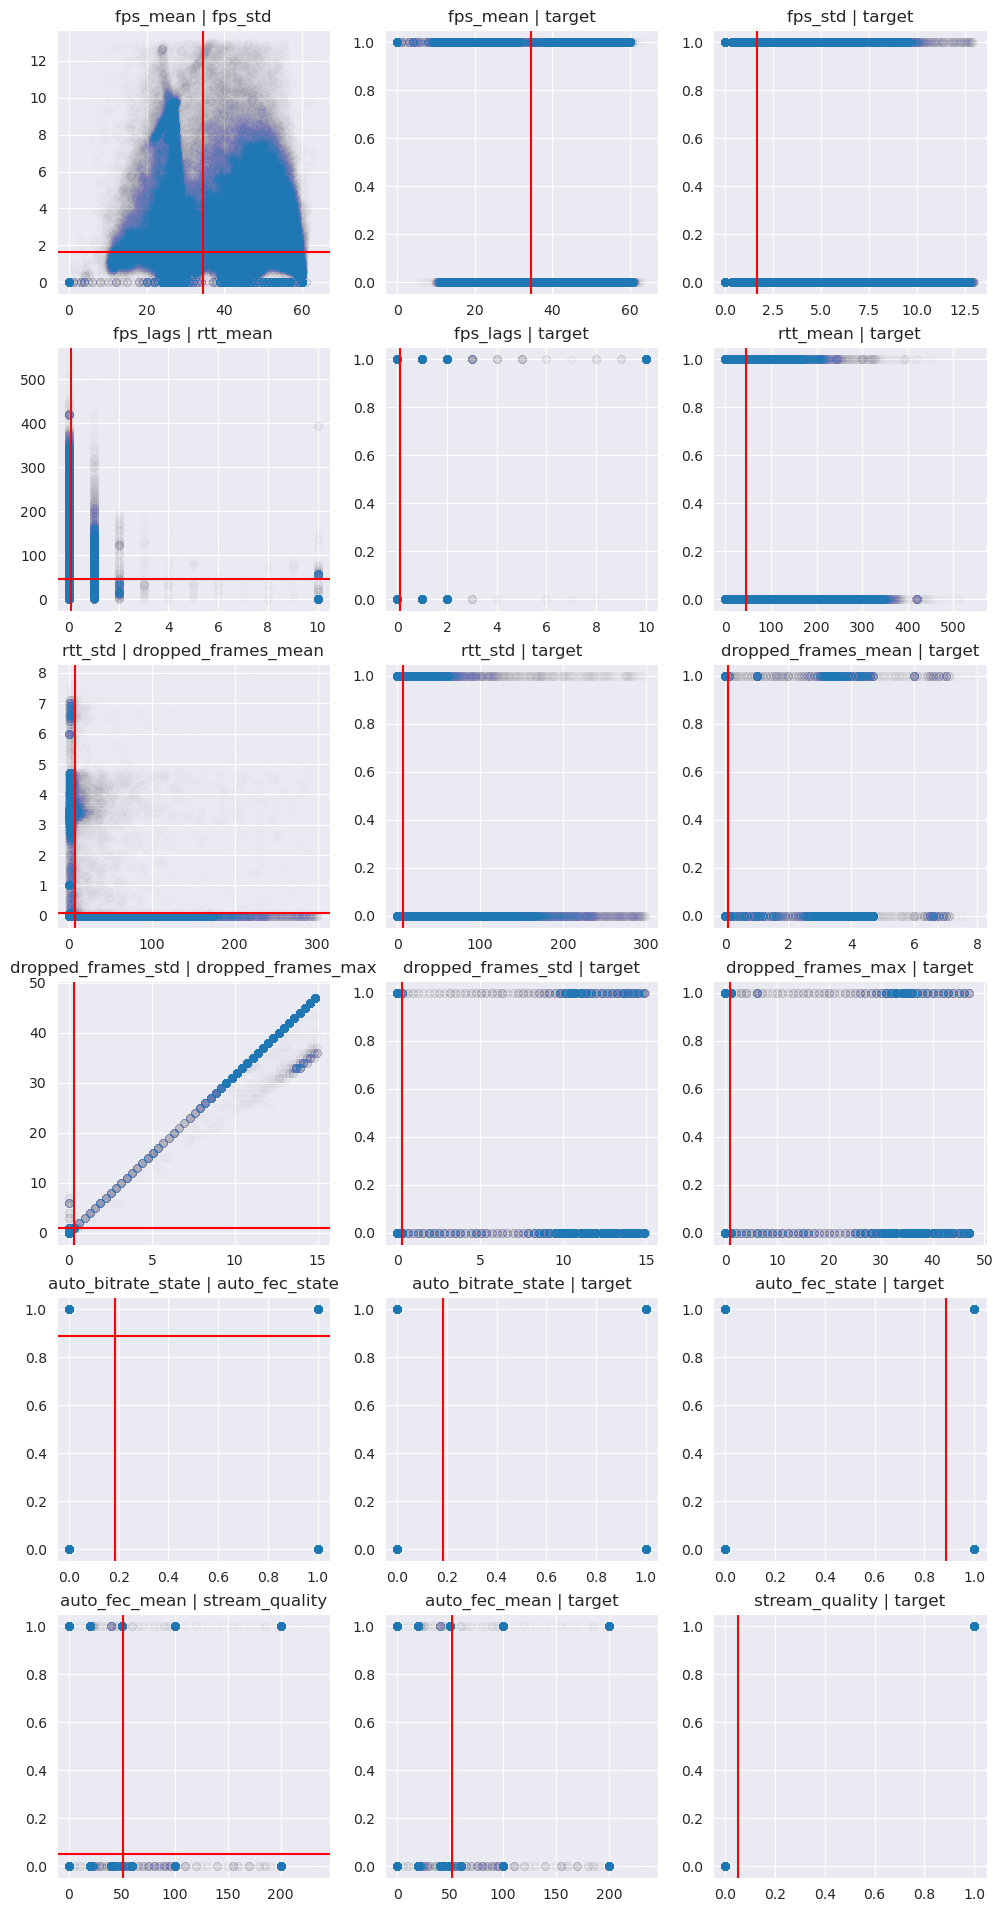

In [51]:
print(x_train_c_embbedded.shape)
x_train_c_cleared = x_train_c_embbedded.copy()
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["fps_std"] < 13]
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["fps_mean"] < 65]
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["rtt_mean"] < 600]
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["dropped_frames_mean"] < 8]
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["rtt_std"] < 300]
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["dropped_frames_std"] < 15]
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["dropped_frames_max"] < 50]

print(x_train_c_cleared.shape)
plot_dataset(x_train_c_cleared, x_train_c_cleared["stream_quality"])

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

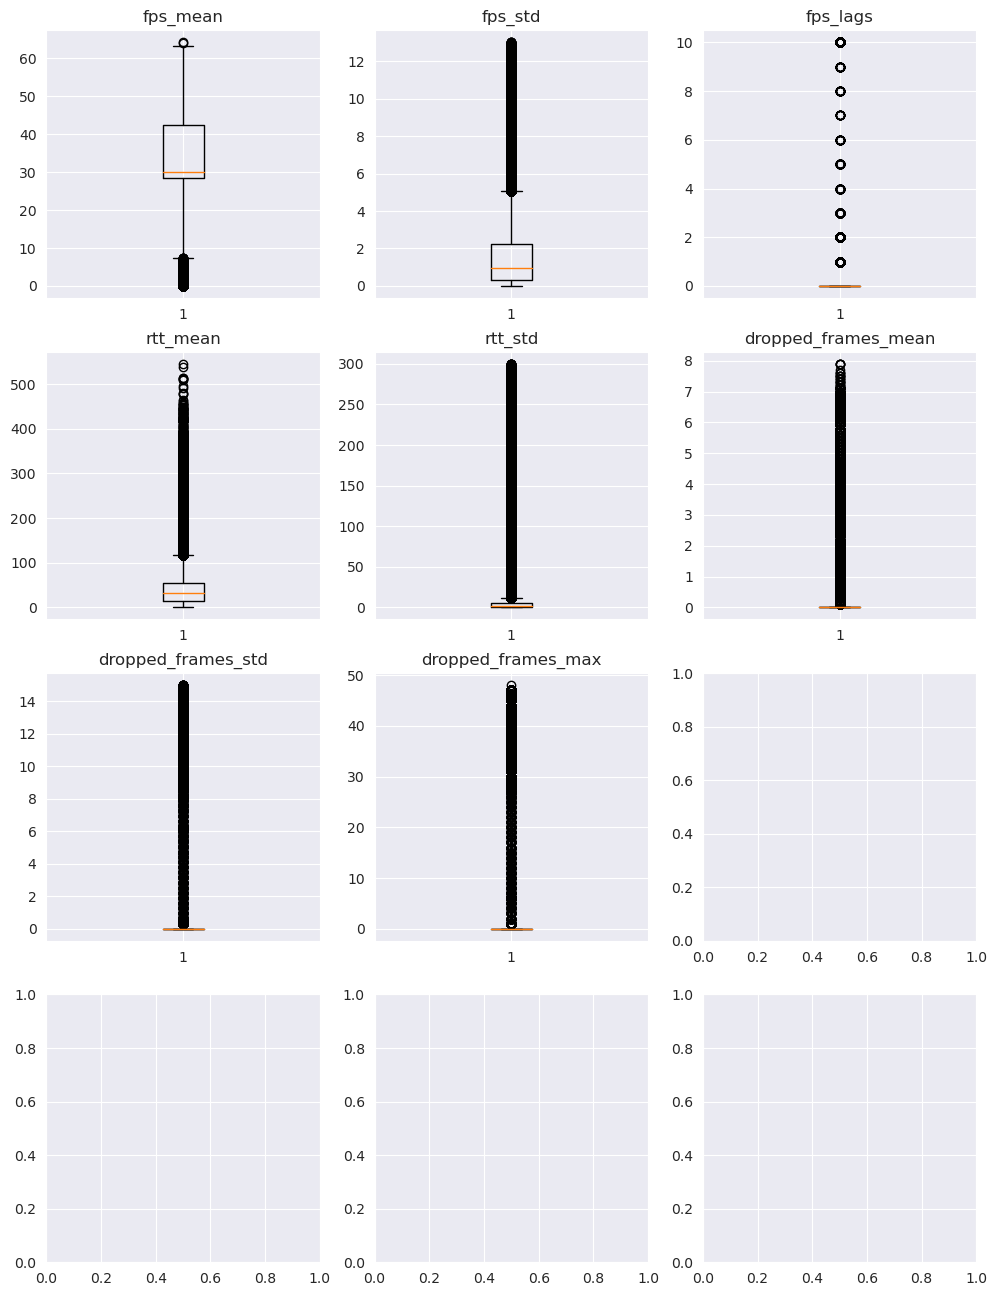

In [52]:
plot_boxplots(x_train_c_cleared)

0    378738
1     27834
Name: stream_quality, dtype: int64


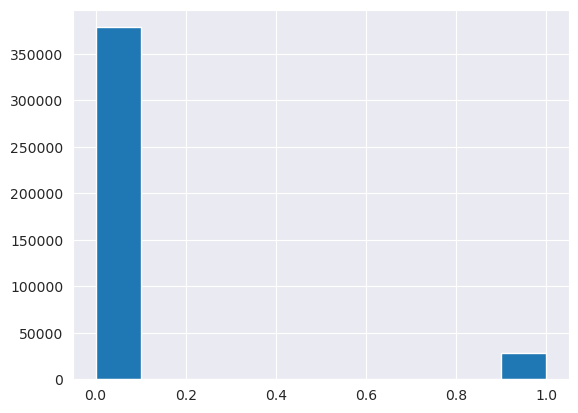

In [53]:
print(x_train_c_embbedded["stream_quality"].value_counts())
x_train_c_embbedded["stream_quality"].hist()
plt.show()

In [54]:
def class_pipe(X_, y=False, fit_mode=False):
    X = X_.copy()

    X.drop(["dropped_frames_max"], inplace=True, axis=1)

    X["auto_bitrate_state"] = X["auto_bitrate_state"].apply(lambda x: x!="off")
    X["auto_fec_state"] = X["auto_fec_state"].apply(lambda x: x!="off")

    X['dropped_frames_occured'] = X['dropped_frames_mean'].apply(lambda x: np.int8(x>0))
    #X['dropped_frames_mean_log'] = X['dropped_frames_mean'].apply(lambda x: np.log(x) if x>2 else x)
    X['fps_unstable'] = X['fps_std'].apply(lambda x: x>5)
    #X['fps_highly_unstable'] = X['fps_std'].apply(lambda x: x>15)
    X["fps_std_log"] = X["fps_std"].apply(lambda x: np.log(x) if x>2 else x)
    X['rtt_unstable'] = X['rtt_std'].apply(lambda x: x>5)
    X['rtt_std_log'] = X['rtt_std'].apply(lambda x: np.log(x) if x>2 else x)
    X['fps_anomaly'] = X['fps_mean'].apply(lambda x: not (x>20 and x<30))
    X['rtt_anomaly'] = X['rtt_mean'].apply(lambda x: x>50)
    #X['fps_lag_occured'] = X['fps_lags'].apply(lambda x: x>0)
    X['rtt_mean_log'] = X['rtt_mean'].apply(lambda x: np.log(x) if x>2 else x)
    #X['auto_fec_mean_high'] = X['auto_fec_mean'].apply(lambda x: x > 100)
    X['auto_fec_mean_log'] = X['auto_fec_mean'].apply(lambda x: np.log(x) if x>2 else x)
    X.drop(["dropped_frames_mean"], axis=1, inplace=True)

    if fit_mode:
        X["stream_quality"] = y
        X.drop_duplicates(inplace = True)

        X = X.loc[X["fps_std"] < 13]
        X = X.loc[X["fps_mean"] < 65]
        X = X.loc[X["rtt_mean"] < 600]
        X = X.loc[X["rtt_std"] < 300]
        X = X.loc[X["dropped_frames_std"] < 15]

    if "stream_quality" in X.columns:
        y = X["stream_quality"]
        X = X.drop("stream_quality", axis=1)

    global scaler
    if fit_mode:
        scaler = MinMaxScaler().fit(X)

    X = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

    # X = X.apply(lambda x: x - np.mean(x), axis=1)

    if type(y) != bool:
        return X, y
    return X



In [55]:
x_train_c_piped, y_train_c = class_pipe(x_train_c.drop("stream_quality", axis=1),x_train_c["stream_quality"], fit_mode=True)
x_train_c_piped["stream_quality"] = y_train_c
x_train_c_positive = x_train_c_piped.loc[x_train_c_piped["stream_quality"] > 0]
x_train_c_negative = x_train_c_piped.loc[x_train_c_piped["stream_quality"] == 0]
print(x_train_c_positive.shape, x_train_c_negative.shape)
x_train_c_negative_1 = x_train_c_negative.sample(int(x_train_c_positive.shape[0]), random_state=RANDOM_STATE)
x_train_c_batch_1 = pd.concat([x_train_c_positive, x_train_c_negative_1])
x_train_c_batch_1["stream_quality"].value_counts()
x_train_c_piped.drop("stream_quality", axis=1, inplace=True)

(16830, 19) (333263, 19)


0.6287100856058248
0.08116431257587871
0.6287100856058246
0.7331803655566907


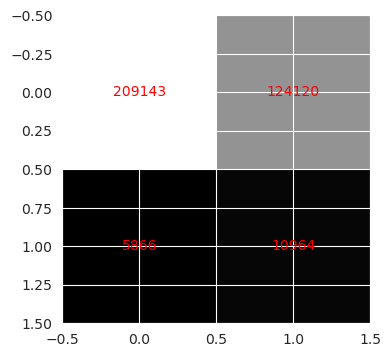

3

In [98]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

#x = x_train_c_batch_1.drop("stream_quality", axis=1)
#y = x_train_c_batch_1["stream_quality"]

x = x_train_c_piped
y = y_train_c

threshold = 0.55

model = LogisticRegression(max_iter=1000, class_weight="balanced").fit(x, y)
y_pred = model.predict_proba(x)[:,0] < threshold

print(accuracy_score(y, y_pred))
print(precision_score(y, y_pred, average="weighted"))
print(recall_score(y, y_pred, average="weighted"))
print(f1_score(y, y_pred, average="weighted"))

plot_confusion_matrix(y, y_pred)
roc = roc_curve(y, model.predict_proba(x)[:,0])
len(roc)

In [ ]:
y_proba = model.predict_proba(x)[:,0]
thr = np.arange(0.0, 1.0, 0.01)
precision = [precision_score(y, y_proba < i) for i in thr]
recall = [recall_score(y, y_proba < i) for i in thr]
accuracy = [accuracy_score(y, y_proba < i) for i in thr]
plt.plot(thr, precision)
plt.plot(thr, recall)
plt.plot(thr, accuracy, c = 'green')

plt.show()

In [58]:
class Classifier:
    def __init__(self, model, threshold=0.5):
        self.model=model
        self.threshold=threshold
    def fit(self, x, y):
        self.model.fit(x, y)
    def predict(self, x):
        return self.model.predict_proba(x)[:,0] < self.threshold

In [59]:
pd.DataFrame(model.coef_, columns=x_train_c_piped.columns).T

,0
fps_mean,-1.206601
fps_std,0.985882
fps_lags,8.601436
rtt_mean,1.949377
rtt_std,0.876651
dropped_frames_std,0.640114
auto_bitrate_state,0.270619
auto_fec_state,1.730978
auto_fec_mean,0.650586
dropped_frames_occured,0.760957


In [60]:
threshold = 0.54

#x = x_train_c_batch_1.drop("stream_quality", axis=1)
#y = x_train_c_batch_1["stream_quality"]

x = x_train_c_piped
y = y_train_c

models = {
    "Logistic_l1" : Classifier(LogisticRegression(penalty="l1", max_iter=200, class_weight='balanced', solver="saga"), threshold=0.55),
    "Logistic_l2" : Classifier(LogisticRegression(penalty="l2", max_iter=1000, class_weight='balanced'), threshold),
    "Ridge" : RidgeClassifier(max_iter=100, class_weight='balanced'),
    "Polynomial_d2" : Polynomial(2, model=Classifier(LogisticRegression(max_iter=300, class_weight='balanced'), threshold)),
    "Polynomial_d3" : Polynomial(3, model=Classifier(LogisticRegression(max_iter=300, class_weight='balanced'), threshold))
}

metrics = {
    "accuracy_score" : lambda x, y: accuracy_score(x, y),
    "precision_score" : lambda x, y: precision_score(x, y, average = "weighted"),
    "recall_score" : lambda x, y: recall_score(x, y, average = "weighted"),
    "f1_score" : lambda x, y: f1_score(x, y, average = "weighted")
}

x_test_c_piped, y_test_c_piped = class_pipe(x_test_c.drop("stream_quality", axis=1), x_test_c["stream_quality"])

print("Train data")
for n in models:
    print(f'{n} :\n{evaluate_model(models[n], x, y, x_train_c_piped, y_train_c, fit_model=True, metrics=metrics)[0]}')

print("\nTest data")
for n in models:
    print(f'{n} :\n{np.round(evaluate_model(models[n], None, None, x_test_c_piped, y_test_c_piped, fit_model=False, metrics=metrics)[0],4)}')



#plot_confusion_matrix(y_train_c, out[2])

Train data
Logistic_l1 :
{'accuracy_score': 0.39943672109982203, 'precision_score': 0.933326227257184, 'recall_score': 0.39943672109982203, 'f1_score': 0.5244457653145284}
Logistic_l2 :
{'accuracy_score': 0.6590934408857075, 'precision_score': 0.9293973205674252, 'recall_score': 0.6590934408857075, 'f1_score': 0.7561839574764752}
Ridge :
{'accuracy_score': 0.7525029063705929, 'precision_score': 0.9279465445755651, 'recall_score': 0.7525029063705929, 'f1_score': 0.8216590174756699}
Polynomial_d2 :
{'accuracy_score': 0.7105654783157618, 'precision_score': 0.9321896732572186, 'recall_score': 0.7105654783157618, 'f1_score': 0.7932583635104596}
Polynomial_d3 :
{'accuracy_score': 0.6984658362206614, 'precision_score': 0.9333017769805387, 'recall_score': 0.6984658362206615, 'f1_score': 0.7847255710161577}

Test data


TypeError: unsupported operand type(s) for *: 'dict' and 'float'

In [ ]:
plot_dataset(x_train_c_piped, y_train_c)

In [ ]:
plot_boxplots(x_train_c_piped)

In [ ]:
x_train_c_piped["fps_lags"].value_counts()

In [ ]:
y_train_r.hist(bins=30)
pd.Series(y_train_pred_r).hist(bins=30)
plt.axvline(np.mean(y_train_r), c = "red")
plt.ylim([0, 50000])
plt.xlim([0, 22000])
plt.show()